In [ ]:
using ProgressBars
#using Plots
using CairoMakie
using Serialization

using QuantumOptics
using LinearAlgebra
using ExponentialUtilities

const NDIMS = 100
const L0 = 10.0
const V = 1e-2
const α0 = 2*pi

const T_c = 1.0
const T_h = 10.0

const STEP_SIZE = 1e-2
const STROKE_TIME = 1

const INTERACTION_STRENGTH = 1.0

const MAX_CYCLES = 2;

## Plotting Functions

In [ ]:
function plot_first_adiabatic(system, time)
	system, entropies, temperatures = adiabatic_compression(system, time=time)
	entropies = round.(real.(entropies), digits=4)
	temperatures = round.(real.(temperatures), digits=4)
	println(entropies)
	entropy = round.(real.(QuantumOptics.entropy_vn(system)), digits=4)
	println("Real Entropy: $entropy")
	println(temperatures)
	temperature = round.(real.(temperature_of_system(system, H(STROKE_TIME))), digits=4)
	println("Real Temperature: $temperature")
	lines(entropies, temperatures)
end

function plot_e_vs_t(entropies, temperatures)
	# Plot entropy vs. temperature
	entropies = round.(real.(entropies), digits=4)
	temperatures = round.(real.(temperatures), digits=4)
	lines(entropies, temperatures, ylabel="Temperature (K)", xlabel="Entropy", title="Entropy vs. Temperature")
end
;

In [ ]:
max_len = L0 + V * STROKE_TIME
min_len = L0 - V * STROKE_TIME

"""
This simulate the movement of the cavity:
- Cooling,
- Compression,
- Heating,
- Expansion
"""
function cavity_len(t, l0=L0, v=V)
	st = STROKE_TIME
	period = 4 * st
	t_mod = mod(t, period)
	if t_mod <= st
		t = t_mod
        return l0 + v * t
    elseif t_mod <= 2 * st
		t = t_mod - st
        return l0 + v * st
    elseif t_mod <= 3 * st
		t = t_mod - 2 * st
        return l0 + v * (st - t)
    else
        return l0
    end
end

t_values = [0:10*STROKE_TIME;]
y_values = [cavity_len(t) for t in t_values]
println("Cavity length goes from $min_len to $max_len, strating from $L0")

# Frequencies of the cavity
ω = α0 / L0
ω_cold = α0 / max_len
ω_hot = α0 / min_len
println("Cavity frequency goes from $ω_cold to $ω_hot, strating from $ω")
	
# Plot the function
f = Figure()
ax = Axis(f[1, 1], xlabel="Time", ylabel="Cavity Length", title="Cavity Length vs. Time")
lines!(t_values, y_values)
f

## Maser Bath Initialization

In [ ]:
boltzmann_population(omega, temp) = 1 / (ℯ^(omega / temp) + 1)

# Populations of the cavity in the cold and hot baths
p_cold = boltzmann_population(ω_cold, T_c)
p_hot = boltzmann_population(ω_hot, T_h)

println("Maser Exited Population: $p_hot")
println("Maser Ground Population: $p_cold")

In [ ]:
# Operators and Hamiltonian
basis = QuantumOptics.FockBasis(NDIMS)

a = QuantumOptics.destroy(basis)
ad = QuantumOptics.create(basis)
n = QuantumOptics.number(basis)

# Bosonic Operators
θ = INTERACTION_STRENGTH * STEP_SIZE
c = cos(θ * sqrt(Matrix((ad * a).data)))
cp = cos(θ * sqrt(Matrix((a * ad).data)))
s = a.data * sin(θ * sqrt(Matrix((ad * a).data)))
#sd = inv(Matrix(a.data))
#sd = dagger(s)

Hbase = α0 * ( n + QuantumOptics.identityoperator(basis)*1/2 )

# Time-dependent Hamiltonian
function H(t)
	Hbase / cavity_len(t)
end

display(H(0))

## System State Initialization

In [ ]:
"""
Validates that the Density Operator truncation is justified by small values in the lower right corner
"""
function truncation_valid(system)
	return real(system.data[end, end]) < 1e-4
end
"""
To determine the temperature of a system from its density matrix, you typically need to compare the density matrix to the thermal (Gibbs) state of the system.
Here are the steps to find the temperature:

- Obtain the Hamiltonian (H) of the system.
- Diagonalize the density matrix (\rho) to find its eigenvalues.
- Fit the eigenvalues to the Boltzmann distribution (e^{-\beta E_i}), where (E_i) are the eigenvalues of the Hamiltonian.
"""
function temperature_of_system(state, ω, hamiltonian=nothing)
    if hamiltonian
		# Diagonalize the density matrix
		# This will return eigenvalues in ascending order
		eigenvalues = LinearAlgebra.eigvals(state.data) 
		
		# Calculate the inverse temperature beta
		eig1 = real(eigenvalues[end-1])
		eig2 = real(eigenvalues[end])
		beta = -log(eig1 / eig2) / (hamiltonian.data[2, 2] - hamiltonian.data[1, 1])
		
		# Calculate the temperature
		# k_B = 1.380649e-23  # Boltzmann constant in J/K
		T = 1 / Real(beta)
	else
		# Valid only for thermal states
		ratio = state.data[1, 1] / state.data[2, 2]
		T = ω / log(ratio)
end

"""
Measures Temperature and Entropy of the System and update the list of measures
"""
function add_system_measure(system, time, temp_array, entropy_array)
	temp = round.(real.(temperature_of_system(system, H(time))), digits=6)
	# println(temp)
	entropy = round.(real.(QuantumOptics.entropy_vn(system)), digits=6)
	push!(temp_array, temp)
	push!(entropy_array, entropy)
end
;

In [ ]:
systems = []

# Try to load an initial state or create one new thermal state
try
	open("starting_state_maser.dat", "r") do f
		global system = deserialize(f)
		global stabilized = true
	end
catch y
	@warn "No starting state: $y.\nStarting from a Thermal State"
	global system = QuantumOptics.thermalstate(H(0), T_c)
	global stabilized = false
end


push!(systems, system)
# Check the initial system
valid_truncation = truncation_valid(system)
t_initial = round(temperature_of_system(system, H(0)), digits=6)
println("Truncation is valid: $valid_truncation")
println("System starting at temperature: $t_initial")

## Dynamics

In [ ]:
"""
This process keeps the Entropy stable while changing the Temperature.
This is done moving artificially the piston, changing the length of the Cavity.
In this stroke only work is done without heat exchange
"""
function adiabatic_compression(system0; time::Int64=0, dt=STEP_SIZE, stroke_time=STROKE_TIME)
	system = system0
	entropies = zeros(eltype(system), Int64(stroke_time/dt))
	temperatures = zeros(eltype(system), Int64(stroke_time/dt))
	for (step, t) in enumerate(1:dt:stroke_time)
		h = H(t + time)
		try
			entropies[step] = QuantumOptics.entropy_vn(system, tol=1e-18)
			temperatures[step] = temperature_of_system(system, h)
		catch e
			println("Error in measuring the system: ", e)
		end

		if !(truncation_valid(system))
			error = real(system.data[end, end])
			throw(ErrorException("Hilbert truncation no more valid at step $t with lower end $error"))
		end

		# Evolve the system
		U = QuantumOptics.exp(-im * h)
		Ud = QuantumOptics.dagger(U)
		system = U * system * Ud
		# println(display(system.data[1:2, 1:2]))
	end
	return system, entropies, temperatures
end

"""
This process heats up or cools down the cavity field, with a Dissipative Master Equation
"""
function heating(system, rate, ad, a; time::Int64=0, dt=STEP_SIZE, stroke_time=STROKE_TIME)
	t = [1:stroke_time/dt;]
	h = H(time)
	tout, systems = QuantumOptics.timeevolution.master(t, system, h, [ad, a], rates=[rate, 1-rate])
	return systems[end]
end

# FULL CYCLE
"""
Implements the full thermodynamic cycle:
- Adiabatic compression
- Isochoric Heating
- Adiabatic Expansion
- Isochoric Cooling
"""
function cycle(tspan, system0)
	system = system0
	temperatures = [round.(real.(temperature_of_system(system, H(0))), digits=6);]
	entropies = [round.(real.(QuantumOptics.entropy_vn(system)), digits=6);]
	current_time = 0
	for t in ProgressBar(1:tspan)		
		# Adiabatic Compression
		system, _, _ = adiabatic_compression(system; time=current_time)
		current_time += STROKE_TIME
		add_system_measure(system, current_time, temperatures, entropies)
		# println(temperature_of_system(system, H(current_time)))
		
		# Isochoric Heating
		system = heating(system, p_hot, ad, a; time=current_time)
		current_time += STROKE_TIME
		add_system_measure(system, current_time, temperatures, entropies)

		# Adiabatic Expansion
		system, _ = adiabatic_compression(system; time=current_time)
		current_time += STROKE_TIME
		add_system_measure(system, current_time, temperatures, entropies)

		# Isochoric Cooling
		system = heating(system, p_cold, ad, a, time=current_time)
		current_time += STROKE_TIME
		add_system_measure(system, current_time, temperatures, entropies)
	end
	println("Final time $current_time")
	return system, temperatures, entropies
end
;

Stabilize the system if it was created anew

In [ ]:
if stabilized
	system_stable, temp_cycles, entrop_cycles = cycle(1, system)
else
	system_stable, temp_cycles, entrop_cycles = cycle(3, system)
    stabilized = true
end

plot(entrop_cycles, temp_cycles)

t_sys = round(temperature_of_system(system, H(0)), digits=6)
println("Final Temperature: $t_sys")

In [ ]:
# Save the state
open("starting_state_maser.dat", "w") do f
	serialize(f, system_stable)
end

# Phaseonium

In [ ]:
RELOAD_STABLE_STATE = false

if RELOAD_STABLE_STATE
    open("starting_state_maser.dat", "r") do f
    	system_stable = deserialize(f)
    end
end

In [ ]:
# Setup Parameters
function set_parameters(;α²=1/4, ϕ=π/2, χ₁=π/4, χ₂=π/4)
	β²= 1-α²
	return α², β², ϕ, χ₁, χ₂
end

In [ ]:
"""
Calculates the apparent temperature of phaseonium atoms
"""
function phaseonium_temperature(ω::Float64, parameters)
    α², β², ϕ, χ₁, χ₂ = parameters
    γₐ = 2α²
    γᵦ = β²*(1 + cos(ϕ))
    return - ω/ω / log(γₐ/γᵦ)
end
alphas = range(0, 1, length=100)
phis = range(0, π, length=100)
temp = [phaseonium_temperature(ω, set_parameters(α²=a, ϕ=p)) for p in phis, a in alphas]
temp = [t>0 ? t : Inf for t in temp]

f = Figure(px_per_unit=2, size=(800, 400))
Axis(f[1, 1], title = "Apparent Temperature of Phaseonium", xlabel = "ϕ", ylabel="α²")
co = contourf!(phis, alphas, temp,
	levels=range(0, 20, length=100), extendhigh=:magenta)
#contour!(phis, alphas, temp, levels=range(0, 50, length=50))
Colorbar(f[1, 2], co)
f

In [ ]:
function dissipator(o, k1, k2)
    return k1*o*k2 - 1/2 * (k2*k1*o + o*k2*k1)
end


function phaseonium_master_equation(system, rates, operators, dt, Ω)
	γₐ, γᵦ = rates
	a, ad = operators
	# c, cp, s, sd = operators
	θ² = (Ω*dt)^2
	ds = θ²*γₐ*dissipator(system, ad, a) + θ²*γᵦ*dissipator(system, a, ad)
    return ds
end


"""
Implement the fully-coherent phaseonium Master Equation for one cavity.
"""
function phaseonium_stroke(system, parameters, a, ad; 
                time::Int64=0, dt=STEP_SIZE, stroke_time=STROKE_TIME, Ω=INTERACTION_STRENGTH)
    
	entropies = zeros(Float64, Int64(stroke_time/dt + 1))
	temperatures = zeros(Float64, Int64(stroke_time/dt + 1))
	systems = []
	α², β², ϕ, χ₁, χ₂ = parameters
	h_work = (χ₁ + χ₂)ad
	h = H(time) - (h_work + QuantumOptics.dagger(h_work))
	#tout, systems = QuantumOptics.timeevolution.master(t, system, h, [ad, a], rates=[2α², β²*(1+cos(ϕ))])
	step = 1
	total_time = 0:dt:stroke_time
	for t in total_time
		#push!(systems, system)
		
		try
			entropies[step] = QuantumOptics.entropy_vn(system, tol=1e-18)
			temperatures[step] = temperature_of_system(system, h)
		catch e
			println("Error in measuring the system: ", e)
		end

		if !(truncation_valid(system))
			error = real(system.data[end, end])
			throw(ErrorException("Hilbert truncation no more valid at step $t with lower end $error"))
		end
		
		# Evolve the system
		system += phaseonium_master_equation(system, [2*α², β²*(1+cos(ϕ))], [a, ad], dt, Ω)
		
		step += 1
	end
	return system, entropies, temperatures
end

In [ ]:
# TRY
if true
    system_try = QuantumOptics.thermalstate(H(0), T_c)
    parameters = set_parameters(α²=0.3, ϕ=π/4, χ₁=0.0, χ₂=0.0)

    println("Phaseonium Parameters: $parameters")
    println("Initial Temperature: $(temperature_of_system(system, H(0)))")
    println("Stable Temperature of the Phaseonium $(phaseonium_temperature(ω, parameters))")

	initial_time = STROKE_TIME
    time = STROKE_TIME
    dt = STEP_SIZE / 10
    
    system, s_evolution, t_evolution = phaseonium_stroke(system_try, parameters, a, ad; time=initial_time, dt=dt, stroke_time=time)
    println("Final Temperature: $(temperature_of_system(system, H(time)))")
    #catch exception
    #    s_evolution = [0]
    #    t_evolution = [0]
    #    println("Invalid parameter configuration.\n$exception")
    #end
    plot([0:dt:time;], t_evolution)
end

In [45]:
cavity_len(initial_time+time)

10.01

In [17]:
# FULL PHASEONIUM CYCLE
function phaseonium_cycle(tspan, system0; heating_params, cooling_params)
	system = system0
	temperatures = [round.(real.(temperature_of_system(system, H(0))), digits=6);]
	entropies = [round.(real.(QuantumOptics.entropy_vn(system)), digits=6);]
	current_time = 0
	for t in ProgressBar(1:tspan)
        println("Cycle t$t")
		# Adiabatic Compression
		system, _ = adiabatic_compression(system; time=current_time)
		current_time += STROKE_TIME
		add_system_measure(system, current_time, temperatures, entropies)
		println(temperature_of_system(system, H(current_time)))
		
		# Isochoric Heating
		system = phaseonium_stroke(system, heating_params, ad, a)
		current_time += STROKE_TIME
		add_system_measure(system, current_time, temperatures, entropies)

		# Adiabatic Expansion
		system, _ = adiabatic_compression(system; time=current_time)
		current_time += STROKE_TIME
		add_system_measure(system, current_time, temperatures, entropies)

		# Isochoric Cooling
		system = phaseonium_stroke(system, cooling_params, ad, a)
		current_time += STROKE_TIME
		add_system_measure(system, current_time, temperatures, entropies)
	end
	println("Final time $current_time")
	return system, temperatures, entropies
end



phaseonium_cycle (generic function with 1 method)

In [18]:
println("Apparent Tempreatures for the Phaseonium Cycle:")

phaseonium_parameters = set_parameters(α²=0.3, ϕ=π/4, χ₁=0, χ₂=0)
temp = phaseonium_temperature(ω, phaseonium_parameters)
println("Coherent Phaseonium: $temp")

thermal_parameters = set_parameters(α²=0.25, ϕ=0, χ₁=0, χ₂=0)
temp = phaseonium_temperature(ω, thermal_parameters)
println("Thermal Phaseonium: $temp")

Apparent Tempreatures for the Phaseonium Cycle:
Coherent Phaseonium: 1.4514827171419424
Thermal Phaseonium: 0.9102392266268373


In [19]:
#phaseonium_cycle(1, system_stable, heating_params=phaseonium_parameters, cooling_params=thermal_parameters) 

In [20]:
temperature_of_system(system_stable, H(0))

LoadError: UndefVarError: `system_stable` not defined

In [21]:
begin
    current_time = 2*STROKE_TIME  # We skip cooling and compression
    println("Starting len:\t$(cavity_len(current_time))")
    # Adiabatic Compression
    system, _ = adiabatic_compression(system_stable; time=current_time)
    current_time += STROKE_TIME
    println("T = $(temperature_of_system(system, H(current_time)))")
    println("After Compression:\t$(cavity_len(current_time))")
    
    # Isochoric Heating
    system = phaseonium_stroke(system, phaseonium_parameters, ad, a; stroke_time=20)
    #system = heating(system, p_hot, ad, a)
    current_time += STROKE_TIME
    println("Last element:\t$(system.data[end, end])")
    println("T = $(temperature_of_system(system, H(current_time)))")
    println("After Heating:\t$(cavity_len(current_time))")

    # Adiabatic Expansion
    system, _ = adiabatic_compression(system; time=current_time)
    current_time += STROKE_TIME
    println("T = $(temperature_of_system(system, H(current_time)))")
    println("After Expansion:\t$(cavity_len(current_time))")
    
    # Isochoric Cooling
    system = phaseonium_stroke(system, thermal_parameters, ad, a; stroke_time=20)
    current_time += STROKE_TIME
    println("T = $(temperature_of_system(system, H(current_time)))")
    println("After Cooling:\t$(cavity_len(current_time))")
    
end

Starting len:	10.01


LoadError: UndefVarError: `system_stable` not defined

1.0


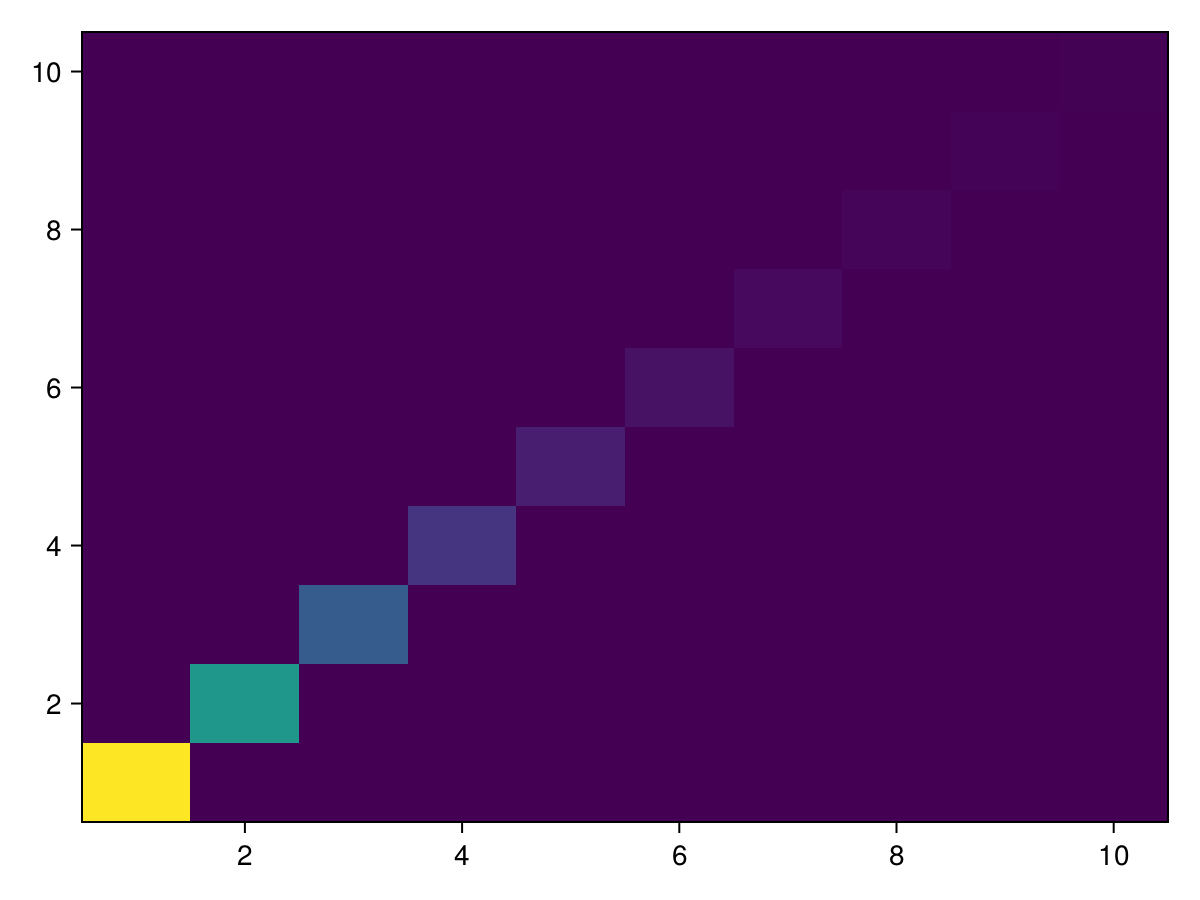

In [22]:
system = QuantumOptics.thermalstate(H(0), T_c)
println(temperature_of_system(system, H(0)))
heatmap(real(system.data[1:10,1:10]))